# Artificial Neural Network Block 1 (Block1)
Without reservoir dynamics

## Data Processing

In [1]:
import sys
from pathlib import Path
import pandas as pd
# import geopandas as gpd
import numpy as np
import os
from pathlib import Path
import time
from random import randint
import json


from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import KFold, ShuffleSplit, RepeatedKFold, train_test_split, GridSearchCV
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor

import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt

import HydroErr as he
import pickle

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2023-10-29 20:41:31.792091: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Using TensorFlow backend


In [2]:
proj_dir = Path("../../..")

In [3]:
utils = str(proj_dir / 'utils')
sys.path.insert(0, utils)
from sql import connect # utility functions for connecting to MySQL

In [4]:
# Create a connection object to the MySQL database
# conn = connect.Connect(str(proj_dir / "Methods/2.Data/DBManagement/mysql_config.ini"))
conn = connect.Connect(str(proj_dir / ".env/mysql_config.ini"))
connection = conn.conn

Connecting to MySQL database...
Connection established.


In [5]:
reaches_and_dams = pd.read_csv(proj_dir / "Methods/machine_learning/ML2/reaches_and_dams.csv")

In [6]:
reaches_of_interest = ["Columbia_River_59","Willamette_River_15", "Kootenay_River_47", "Okanogan_River_29"]
# also test for Willamette_River_16, Kootenay_River_47, 

In [7]:
# query = f"""
# SELECT 
#     STR_TO_DATE(CONCAT(Year,
#                     '-',
#                     LPAD(Month, 2, '00'),
#                     '-',
#                     LPAD(DayOfMonth, 2, '00')),
#             '%Y-%m-%d') AS Date,
#     Month,
#     DayOfMonth,
#     ROUND(WaterTemp, 2) as WaterTemp,
#     ROUND(LandTemp, 2) as LandTemp,
#     ROUND(NDVI, 2) as NDVI,
#     ClimateClass,
#     --     ROUND(((watertemp - WaterTemperature) / WaterTemperature),
#     --             2) AS PercentDeviation,
#     --     ROUND((watertemp - WaterTemperature), 2) AS Deviation,
#     Width,
#     ReachID,
#     ReachName,
#     ROUND(InsituTemp, 2) AS InsituTemp
# FROM
#     (SELECT 
#         IF(DAY(ReachLandsatWaterTemp.date) < 15, 1, 15) AS DayOfMonth,
#             MONTH(ReachLandsatWaterTemp.date) AS Month,
#             YEAR(ReachLandsatWaterTemp.date) AS Year,
#             AVG(ReachLandsatWaterTemp.Value) AS WaterTemp,
#             AVG(ReachLandsatLandTemp.Value) AS LandTemp,
#             AVG(ReachNDVI.Value) AS NDVI,
#             IFNULL(Reaches.WidthMean, 30) AS Width,
#             Reaches.ClimateClass AS ClimateClass,
#             ReachLandsatWaterTemp.ReachID AS ReachID,
#             Reaches.Name AS ReachName
#     FROM
#         ReachLandsatWaterTemp
#     INNER JOIN ReachLandsatLandTemp USING (date , ReachID)
#     INNER JOIN ReachNDVI USING (date , ReachID)
#     INNER JOIN Reaches USING (ReachID)
#     -- WHERE
#     --    Reaches.Name NOT IN {tuple(reaches_of_interest)}
#     --        AND ReachLandsatWaterTemp.Value > 0
#     GROUP BY DayOfMonth , Month , Year , ClimateClass , ReachID , Width) AS T
#     --         INNER JOIN
#     --     ReachLandsatLTMSemiMonthly USING (DayOfMonth , Month , ReachID)
#         LEFT JOIN
#     (SELECT 
#         IF(DAY(ReachInsituWaterTemp.date) < 15, 1, 15) AS DayOfMonth,
#             MONTH(ReachInsituWaterTemp.date) AS Month,
#             YEAR(ReachInsituWaterTemp.date) AS Year,
#             AVG(ReachInsituWaterTemp.Value) AS InsituTemp,
#             ReachInsituWaterTemp.ReachID AS ReachID
#     FROM
#         ReachInsituWaterTemp
#     INNER JOIN Reaches USING (ReachID)
#     WHERE
#         ReachInsituWaterTemp.Value > 0
#     GROUP BY DayOfMonth , Month , Year , ReachID) AS I USING (DayOfMonth , Month , Year , ReachID)
# -- ORDER BY RAND();
# """ 
# # print(query)

# df = conn.query_with_fetchmany(query, chunksize=100)

# df.to_csv(proj_dir / "Methods/2.Data/ML_input_data.csv", index=False)

df = pd.read_csv(proj_dir / "Methods/2.Data/ML_input_data.csv")

In [8]:
# df = pd.concat([chunk for chunk in data], ignore_index=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfYear'] = df['Date'].dt.dayofyear

dels = pd.read_csv(proj_dir / "Methods/3.WaterTempEst/rat_dels.csv")
dels["Date"] = pd.to_datetime(dels["Date"])
sarea = pd.read_csv(proj_dir / "Methods/3.WaterTempEst/rat_sarea.csv")
sarea["Date"] = pd.to_datetime(sarea["Date"])

In [9]:
df = df.merge(reaches_and_dams, on="ReachName", how="left")
df = df.merge(dels, on=["GranD_ID", "Date"], how="left")
df = df.merge(sarea, on=["GranD_ID", "Date"], how="left")

df.rename(columns={"dS (m3)": "dels", "area (km2)": "sarea", "Within_n*10km": "rel_dist"}, inplace=True)

original_cols = df.columns
# df.head()

In [10]:
# plot kde of dels
# df[abs(df["dels"])>0]["dels"].plot.kde()
# df["sarea"].plot.kde()
# df["sarea_scaled"].plot.kde()

In [11]:
# Scalers
# load scalers and model
with open(proj_dir / f"Results/2.WaterTempEst/scalers.pkl", "rb") as f:
    scalers = pickle.load(f)

    dayofmonth_scaler = scalers["dayofmonth_scaler"]
    month_scaler = scalers["month_scaler"]
    watertemp_scaler =  scalers["watertemp_scaler"]
    landtemp_scaler = scalers["landtemp_scaler"]
    width_scaler = scalers["width_scaler"]
    NDVI_scaler = scalers["NDVI_scaler"]
    climate_scaler = scalers["climate_scaler"]
    dels_scaler =   scalers["dels_scaler"]
    sarea_scaler = scalers["sarea_scaler"]
    rel_dist_scaler = scalers["rel_dist_scaler"]

# # define scalers
# dayofmonth_scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame({'DayOfMonth': range(1, 15+1)}))
# month_scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame({'Month': range(1, 12+1)}))
# watertemp_scaler = StandardScaler().fit(df[['WaterTemp']])
# landtemp_scaler = StandardScaler().fit(df[['LandTemp']])
# # watertemp_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df3[['WaterTemp']])
# # landtemp_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df3[['LandTemp']])
# width_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df[['Width']])
# NDVI_scaler = StandardScaler().fit(df[['NDVI']])
# # NDVI_scaler = MinMaxScaler(feature_range=(-1, 1)).fit(df3[['NDVI']])
# climate_scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame({'ClimateClass': range(1, 30+1)}))
# dels_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df[['dels']])
# sarea_scaler = MinMaxScaler(feature_range=(0, 1)).fit(df[['sarea']])
# rel_dist_scaler = MinMaxScaler(feature_range=(0, 1)).fit(pd.DataFrame({'rel_dist': range(0, 5+1)}))

# replace missing values for dels, sarea, and rel_dist with the 0
df["dels"].fillna(0, inplace=True)
df["sarea"].fillna(0, inplace=True)
df["rel_dist"].fillna(0, inplace=True)

# Scale values
df["DayOfMonth_scaled"] = dayofmonth_scaler.transform(df[["DayOfMonth"]])
df["Month_scaled"] = month_scaler.transform(df[["Month"]])
df["LandTemp_scaled"] = landtemp_scaler.transform(df[["LandTemp"]])
df["WaterTemp_scaled"] = watertemp_scaler.transform(df[["WaterTemp"]])
df["Width_scaled"] = width_scaler.transform(df[["Width"]])
df["NDVI_scaled"] = NDVI_scaler.transform(df[["NDVI"]])
df["ClimateClass_scaled"] = climate_scaler.transform(df[["ClimateClass"]])
df["dels_scaled"] = dels_scaler.transform(df[["dels"]])
df["sarea_scaled"] = sarea_scaler.transform(df[["sarea"]])
df["rel_dist_scaled"] = rel_dist_scaler.transform(df[["rel_dist"]])

# # save the scalers
# with open(proj_dir / f"Results/2.WaterTempEst/scalers.pkl", "wb") as f:
#     pickle.dump({
#         "dayofmonth_scaler": dayofmonth_scaler,
#         "month_scaler": month_scaler,
#         "watertemp_scaler": watertemp_scaler,
#         "landtemp_scaler": landtemp_scaler,
#         "width_scaler": width_scaler,
#         "NDVI_scaler": NDVI_scaler,
#         "climate_scaler": climate_scaler,
#         "dels_scaler": dels_scaler,
#         "sarea_scaler": sarea_scaler,
#         "rel_dist_scaler": rel_dist_scaler,
#     }, f)

/Users/gdarkwah/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/Users/gdarkwah/opt/anaconda3/envs/tensorflow/lib/python3.11/site-packages/sklearn/base.py:348: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [12]:
# df.head()

In [13]:
# df.columns

In [14]:
handpicked = df[(df["ReachName"].isin(reaches_of_interest)) & (df["InsituTemp"].notnull())].copy()

# X and y to be used for model (excluding handpicked reaches of interest)
X = df[(~df["ReachName"].isin(reaches_of_interest)) & (df["InsituTemp"].notnull())][
    [
        "DayOfMonth_scaled",
        "Month_scaled",
        "LandTemp_scaled",
        "Width_scaled",
        "NDVI_scaled",
        "ClimateClass_scaled",
        # "dels_scaled",
        # "sarea_scaled",
        # "rel_dist_scaled",
    ]
]
y_lsat = df[(~df["ReachName"].isin(reaches_of_interest)) & (df["InsituTemp"].notnull())]["WaterTemp"]
y = df[(~df["ReachName"].isin(reaches_of_interest)) & (df["InsituTemp"].notnull())]["InsituTemp"]

# dev set and test set (including handpicked reaches of interest)
dev_set, test_set = train_test_split(df[(~df["ReachName"].isin(reaches_of_interest)) & (df["InsituTemp"].notnull())], test_size=0.1, random_state=1993)
test_set = pd.concat([test_set, handpicked])

X_dev = dev_set[
    [
        "DayOfMonth_scaled",
        "Month_scaled",
        "LandTemp_scaled",
        "Width_scaled",
        "NDVI_scaled",
        "ClimateClass_scaled",
        # "dels_scaled",
        # "sarea_scaled",
        # "rel_dist_scaled",
    ]
]
y_dev = dev_set["InsituTemp"]
y_dev_lsat = dev_set["WaterTemp"]

X_test = test_set[
    [
        "DayOfMonth_scaled",
        "Month_scaled",
        "LandTemp_scaled",
        "Width_scaled",
        "NDVI_scaled",
        "ClimateClass_scaled",
        # "dels_scaled",
        # "sarea_scaled",
        # "rel_dist_scaled",
    ]
]
y_test = test_set["InsituTemp"]
y_test_lsat = test_set["WaterTemp"]

# X and y for handpicked reaches of interest
X_handpicked = handpicked[
    [
        "DayOfMonth_scaled",
        "Month_scaled",
        "LandTemp_scaled",
        "Width_scaled",
        "NDVI_scaled",
        "ClimateClass_scaled",
        # "dels_scaled",
        # "sarea_scaled",
        # "rel_dist_scaled",
    ]
]
y_handpicked = handpicked["InsituTemp"]
y_handpicked_lsat = handpicked["WaterTemp"]


## Model Development

In [15]:
input_shape = X.shape[1]
# print("Input shape:", input_shape)

In [65]:
model_name = "Block1"

class LsatEquivHyperModel(kt.HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        # Define hyperparameters to tune
        hp_units = hp.Int("units", min_value=8, max_value=64, step=8)
        hp_learning_rate = hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4, 1e-5])
        hp_activation = hp.Choice("activation", values=["linear", "relu"])

        # First layer representing the residual
        l1_inputs = tf.keras.Input(shape=self.input_shape, name="l1_inputs")
        l1_outputs = tf.keras.layers.Dense(
            units=hp_units, activation=hp_activation, name="l1"
        )(l1_inputs)
        residual = tf.keras.Model(inputs=l1_inputs, outputs=l1_outputs, name="residual")

        # Stage 1 block
        stage1_input_shape = residual.output.shape[1]
        stage1_inputs = tf.keras.Input(shape=stage1_input_shape, name="stage1_inputs")
        # output1 = ML1Block(name="output1")(stage1_inputs)

        x1 = tf.keras.layers.Dense(16)(stage1_inputs)
        x1 = tf.keras.layers.Dense(64)(x1)
        x1 = tf.keras.layers.Dense(64)(x1)
        x1 = tf.keras.layers.Dense(16)(x1)
        output1 = tf.keras.layers.Dense(1)(x1)

        stage1 = tf.keras.Model(inputs=stage1_inputs, outputs=output1, name="stage1")

        # Insitu Equivalent Model
        inputs = tf.keras.Input(shape=input_shape, name="inputs")
        residual_output = residual(inputs)
        stage1_output = stage1(residual_output)
        lsat_equiv_model = tf.keras.Model(
            inputs=inputs, outputs=stage1_output, name="lsat_equiv"
        )

        lsat_equiv_model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss=tf.keras.losses.MeanSquaredError(),
            metrics=["mse"],
        )

        return lsat_equiv_model

    def fit(self, hp, model, *args, **kwargs):
        return model.fit(
            *args,
            batch_size=hp.Choice("batch_size", [8, 16, 32, 64]),
            **kwargs,
        )

In [66]:
# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    min_delta=0,
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
    start_from_epoch=0,
)

In [88]:
tuner = kt.GridSearch(
    LsatEquivHyperModel(input_shape),
    objective="val_loss",
    # max_trials=100,
    # factor=3,
    directory=proj_dir / f"Results/2.WaterTempEst/3.ANN/blk1_tuning",
    project_name="kt_tuning",
    overwrite=True,
)

In [89]:
tuner.search(X, y_lsat, epochs=1000, validation_split=0.2, callbacks=[early_stopping])

Trial 256 Complete [00h 00m 32s]
val_loss: 5.796325206756592

Best val_loss So Far: 3.0424599647521973
Total elapsed time: 00h 38m 27s


In [94]:
# get parameters and scores
trials = tuner.oracle.get_best_trials(num_trials=256)
hp_list = []
for trial in trials:
    hp_list.append(trial.hyperparameters.get_config()["values"] | {"Score": trial.score})


hp_df = pd.DataFrame(hp_list)
hp_df.to_csv(proj_dir / f"Results/2.WaterTempEst/3.ANN/{model_name}hp_tuning.csv", index=False)


In [135]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
block1_model = tuner.hypermodel.build(best_hps)
history = block1_model.fit(
    X, y_lsat, epochs=100, validation_split=0.2, 
    callbacks=[early_stopping]
)

{'units': 24, 'learning_rate': 0.01, 'activation': 'relu', 'batch_size': 16}
Epoch 1/100
184/184 [==============================] - 1s 1ms/step - loss: 18.3837 - mse: 18.3837 - val_loss: 10.5021 - val_mse: 10.5021
Epoch 2/100
184/184 [==============================] - 0s 787us/step - loss: 6.9115 - mse: 6.9115 - val_loss: 6.3625 - val_mse: 6.3625
Epoch 3/100
184/184 [==============================] - 0s 774us/step - loss: 6.4471 - mse: 6.4471 - val_loss: 4.5093 - val_mse: 4.5093
Epoch 4/100
184/184 [==============================] - 0s 750us/step - loss: 5.6182 - mse: 5.6182 - val_loss: 6.0232 - val_mse: 6.0232
Epoch 5/100
184/184 [==============================] - 0s 761us/step - loss: 5.0027 - mse: 5.0027 - val_loss: 3.7007 - val_mse: 3.7007
Epoch 6/100
184/184 [==============================] - 0s 754us/step - loss: 5.1534 - mse: 5.1534 - val_loss: 4.0310 - val_mse: 4.0310
Epoch 7/100
184/184 [==============================] - 0s 762us/step - loss: 5.0419 - mse: 5.0419 - val_loss: 3

In [136]:
# save block1_model
block1_model.save(proj_dir / f"Methods/3.WaterTempEst/3.ANN/{model_name}_model.keras")

In [137]:
history_df = pd.DataFrame(history.history)
history_df["epoch"] = history.epoch
history_df["epoch"] = history_df["epoch"] + 1
history_df.to_csv(proj_dir / f"Results/2.WaterTempEst/3.ANN/{model_name}_history.csv", index=False)
# history_df

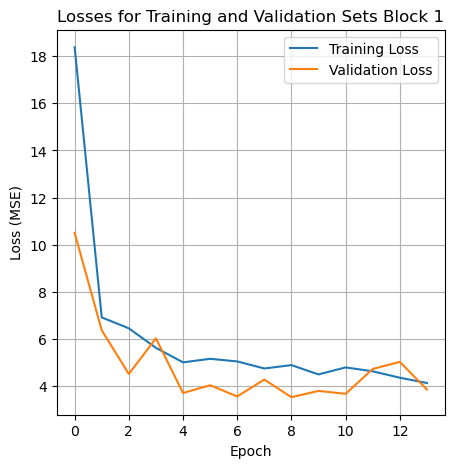

In [138]:
# plot losses for training and validation sets
plt.figure(figsize=(5, 5))
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss (MSE)")
plt.legend()
plt.title("Losses for Training and Validation Sets Block 1")
plt.grid()